# 导入数据

In [2]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

In [3]:
train_data = pd.read_csv('train_all.csv',nrows=10000)
test_data = pd.read_csv('test_all.csv',nrows=100)
train_data.head()

,user_id,merchant_id,age_range,gender,user_cnt,seller_nunique,cat_nunique,brand_nunique,item_nunique,time_stamp_nunique,...,embeeding_93,embeeding_94,embeeding_95,embeeding_96,embeeding_97,embeeding_98,embeeding_99,lgb_clf,xgb_clf,label
0,105600.0,1487.0,6.0,1.0,310.0,96.0,37.0,88.0,217.0,29.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.933521,0.896583,0.0
1,110976.0,159.0,5.0,0.0,274.0,181.0,70.0,159.0,233.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.945943,0.934458,0.0
2,374400.0,302.0,5.0,1.0,278.0,57.0,59.0,62.0,148.0,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.927698,0.930589,0.0
3,189312.0,1760.0,4.0,0.0,237.0,49.0,35.0,45.0,170.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.917096,0.922519,0.0
4,189312.0,2511.0,4.0,0.0,237.0,49.0,35.0,45.0,170.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.938043,0.936024,0.0


In [4]:
features_columns = [col for col in train_data.columns if col not in ['user_id','label']]
train = train_data[features_columns].values
test = test_data[features_columns].values
target =train_data['label'].values

## 切分40%数据用于线下验证

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

(1200, 229) (1200,)
(800, 229) (800,)


0.92875

## 交叉验证

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
scores = cross_val_score(clf, train, target, cv=5)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.9325 0.9325 0.9325 0.9325 0.93  ]
Accuracy: 0.93 (+/- 0.00)


## F1验证

In [7]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0, n_jobs=-1)
scores = cross_val_score(clf, train, target, cv=5, scoring='f1_macro')
print(scores)
print("F1: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.48253558 0.48253558 0.48253558 0.48253558 0.48186528]
F1: 0.48 (+/- 0.00)


# 模型调参

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier


# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.5, random_state=0)

# model
clf = RandomForestClassifier(n_jobs=-1)

# Set the parameters by cross-validation

tuned_parameters = {
                    'n_estimators': [50, 100, 200]
#                     ,'criterion': ['gini', 'entropy']
#                     ,'max_depth': [2, 5]
#                     ,'max_features': ['log2', 'sqrt', 'int']
#                     ,'bootstrap': [True, False]
#                     ,'warm_start': [True, False]
                    }

scores = ['precision']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(clf, tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'n_estimators': 50}

Grid scores on development set:

0.466 (+/-0.002) for {'n_estimators': 50}
0.466 (+/-0.003) for {'n_estimators': 100}
0.466 (+/-0.003) for {'n_estimators': 200}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full evaluation set.

              precision    recall  f1-score   support

         0.0       0.93      0.99      0.96       932
         1.0       0.20      0.03      0.05        68

    accuracy                           0.93      1000
   macro avg       0.57      0.51      0.51      1000
weighted avg       0.88      0.93      0.90      1000




# 绘制模糊矩阵

Confusion matrix, without normalization
[[457   2]
 [ 40   1]]
Normalized confusion matrix
[[1.   0.  ]
 [0.98 0.02]]


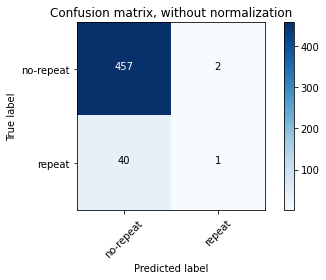

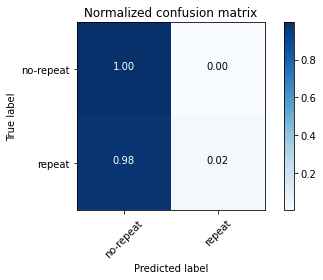

In [9]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# label name
class_names = ['no-repeat', 'repeat']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
clf = RandomForestClassifier(n_jobs=-1)
y_pred = clf.fit(X_train, y_train).predict(X_test)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [10]:
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

# label name
class_names = ['no-repeat', 'repeat']

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(train, target, random_state=0)

# Run classifier, using a model that is too regularized (C too low) to see
# the impact on the results
clf = RandomForestClassifier(n_jobs=-1)
y_pred = clf.fit(X_train, y_train).predict(X_test)

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

   no-repeat       0.92      0.99      0.95       459
      repeat       0.25      0.02      0.04        41

    accuracy                           0.91       500
   macro avg       0.58      0.51      0.50       500
weighted avg       0.86      0.91      0.88       500



# 模型融合

## VOTE模型投票

In [11]:
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler

stdScaler = StandardScaler()
X = stdScaler.fit_transform(train)
y = target


clf1 = LogisticRegression(solver='lbfgs', multi_class='multinomial', random_state=1)
clf2 = RandomForestClassifier(n_estimators=50, random_state=1)
clf3 = AdaBoostClassifier(n_estimators=10)

eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('adb', clf3)], voting='hard')

for clf, label in zip([clf1, clf2, clf3, eclf], ['Logistic Regression', 'Random Forest', 'AdaBoost', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.92 (+/- 0.01) [Logistic Regression]
Accuracy: 0.93 (+/- 0.00) [Random Forest]
Accuracy: 0.93 (+/- 0.01) [AdaBoost]
Accuracy: 0.93 (+/- 0.00) [Ensemble]


## lgb 模型

In [12]:
import lightgbm

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

clf = lightgbm

train_matrix = clf.Dataset(X_train, label=y_train)
test_matrix = clf.Dataset(X_test, label=y_test)
params = {
          'boosting_type': 'gbdt',
          #'boosting_type': 'dart',
          'objective': 'multiclass',
          'metric': 'multi_logloss',
          'min_child_weight': 1.5,
          'num_leaves': 2**5,
          'lambda_l2': 10,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'learning_rate': 0.03,
          'tree_method': 'exact',
          'seed': 2017,
          "num_class": 2,
          'silent': True,
          }
num_round = 10000
early_stopping_rounds = 100
model = clf.train(params,
                  train_matrix,
                  num_round,
                  valid_sets=test_matrix,
                  early_stopping_rounds=early_stopping_rounds)
pre= model.predict(X_valid,num_iteration=model.best_iteration)
print('score : ', np.mean((pre[:,1]>0.5)==y_valid))

[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6627
[LightGBM] [Info] Number of data points in the train set: 1200, number of used features: 124
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Start training from score -0.068100
[LightGBM] [Info] Start training from score -2.720629
[LightGBM] [Warning] No further splits with positive gain, best g

## xgboost 模型

In [13]:
import xgboost

X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=0.4, random_state=0)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

clf = xgboost

train_matrix = clf.DMatrix(X_train, label=y_train, missing=-1)
test_matrix = clf.DMatrix(X_test, label=y_test, missing=-1)
z = clf.DMatrix(X_valid, label=y_valid, missing=-1)
params = {'booster': 'gbtree',
          'objective': 'multi:softprob',
          'eval_metric': 'mlogloss',
          'gamma': 1,
          'min_child_weight': 1.5,
          'max_depth': 5,
          'lambda': 100,
          'subsample': 0.7,
          'colsample_bytree': 0.7,
          'colsample_bylevel': 0.7,
          'eta': 0.03,
          'tree_method': 'exact',
          'seed': 2017,
          "num_class": 2
          }

num_round = 10000
early_stopping_rounds = 100
watchlist = [(train_matrix, 'train'),
             (test_matrix, 'eval')
             ]

model = clf.train(params,
                  train_matrix,
                  num_boost_round=num_round,
                  evals=watchlist,
                  early_stopping_rounds=early_stopping_rounds
                  )
pre = model.predict(z,ntree_limit=model.best_ntree_limit)
print('score : ', np.mean((pre[:,1]>0.5)==y_valid))

[0]	train-mlogloss:0.67493	eval-mlogloss:0.67523
[1]	train-mlogloss:0.65782	eval-mlogloss:0.65839
[2]	train-mlogloss:0.64136	eval-mlogloss:0.64210
[3]	train-mlogloss:0.62561	eval-mlogloss:0.62645
[4]	train-mlogloss:0.61037	eval-mlogloss:0.61149
[5]	train-mlogloss:0.59608	eval-mlogloss:0.59751
[6]	train-mlogloss:0.58225	eval-mlogloss:0.58400
[7]	train-mlogloss:0.56915	eval-mlogloss:0.57106
[8]	train-mlogloss:0.55639	eval-mlogloss:0.55854
[9]	train-mlogloss:0.54458	eval-mlogloss:0.54696
[10]	train-mlogloss:0.53305	eval-mlogloss:0.53569
[11]	train-mlogloss:0.52191	eval-mlogloss:0.52485
[12]	train-mlogloss:0.51136	eval-mlogloss:0.51460
[13]	train-mlogloss:0.50123	eval-mlogloss:0.50463
[14]	train-mlogloss:0.49149	eval-mlogloss:0.49513
[15]	train-mlogloss:0.48229	eval-mlogloss:0.48624
[16]	train-mlogloss:0.47339	eval-mlogloss:0.47751
[17]	train-mlogloss:0.46491	eval-mlogloss:0.46923
[18]	train-mlogloss:0.45654	eval-mlogloss:0.46132
[19]	train-mlogloss:0.44865	eval-mlogloss:0.45361
[20]	train

## 自定义模型
结合Stacking,Bootstrap,Bagging技术实践

In [14]:
"""
    导入相关包
"""
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

In [15]:
class SBBTree():
    """
        SBBTree
        Stacking,Bootstap,Bagging
    """
    def __init__(
                    self,
                    params,
                    stacking_num,
                    bagging_num,
                    bagging_test_size,
                    num_boost_round,
                    early_stopping_rounds
                ):
        """
            Initializes the SBBTree.
            Args:
              params : lgb params.
              stacking_num : k_flod stacking.
              bagging_num : bootstrap num.
              bagging_test_size : bootstrap sample rate.
              num_boost_round : boost num.
              early_stopping_rounds : early_stopping_rounds.
        """
        self.params = params
        self.stacking_num = stacking_num
        self.bagging_num = bagging_num
        self.bagging_test_size = bagging_test_size
        self.num_boost_round = num_boost_round
        self.early_stopping_rounds = early_stopping_rounds

        self.model = lgb
        self.stacking_model = []
        self.bagging_model = []

    def fit(self, X, y):
        """ fit model. """
        if self.stacking_num > 1:
            layer_train = np.zeros((X.shape[0], 2))
            self.SK = StratifiedKFold(n_splits=self.stacking_num, shuffle=True, random_state=1)
            for k,(train_index, test_index) in enumerate(self.SK.split(X, y)):
                X_train = X[train_index]
                y_train = y[train_index]
                X_test = X[test_index]
                y_test = y[test_index]

                lgb_train = lgb.Dataset(X_train, y_train)
                lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

                gbm = lgb.train(self.params,
                            lgb_train,
                            num_boost_round=self.num_boost_round,
                            valid_sets=lgb_eval,
                            early_stopping_rounds=self.early_stopping_rounds)

                self.stacking_model.append(gbm)

                pred_y = gbm.predict(X_test, num_iteration=gbm.best_iteration)
                layer_train[test_index, 1] = pred_y

            X = np.hstack((X, layer_train[:,1].reshape((-1,1))))
        else:
            pass
        for bn in range(self.bagging_num):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=self.bagging_test_size, random_state=bn)

            lgb_train = lgb.Dataset(X_train, y_train)
            lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

            gbm = lgb.train(self.params,
                        lgb_train,
                        num_boost_round=10000,
                        valid_sets=lgb_eval,
                        early_stopping_rounds=200)

            self.bagging_model.append(gbm)

    def predict(self, X_pred):
        """ predict test data. """
        if self.stacking_num > 1:
            test_pred = np.zeros((X_pred.shape[0], self.stacking_num))
            for sn,gbm in enumerate(self.stacking_model):
                pred = gbm.predict(X_pred, num_iteration=gbm.best_iteration)
                test_pred[:, sn] = pred
            X_pred = np.hstack((X_pred, test_pred.mean(axis=1).reshape((-1,1))))
        else:
            pass
        for bn,gbm in enumerate(self.bagging_model):
            pred = gbm.predict(X_pred, num_iteration=gbm.best_iteration)
            if bn == 0:
                pred_out=pred
            else:
                pred_out+=pred
        return pred_out/self.bagging_num

In [18]:
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'num_leaves': 9,
        'learning_rate': 0.03,
        'feature_fraction_seed': 2,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'min_data': 20,
        'min_hessian': 1,
        'verbose': -1,
        'silent': 0
        }

model = SBBTree(params=params,
                stacking_num=5,
                bagging_num=3,
                bagging_test_size=0.33,
                num_boost_round=10000,
                early_stopping_rounds=2000)

In [19]:
model.fit(train, target)

[1]	valid_0's auc: 0.534108
Training until validation scores don't improve for 2000 rounds
[2]	valid_0's auc: 0.625757
[3]	valid_0's auc: 0.640155
[4]	valid_0's auc: 0.651177
[5]	valid_0's auc: 0.646013
[6]	valid_0's auc: 0.638517
[7]	valid_0's auc: 0.629679
[8]	valid_0's auc: 0.625211
[9]	valid_0's auc: 0.651375
[10]	valid_0's auc: 0.63658
[11]	valid_0's auc: 0.635687
[12]	valid_0's auc: 0.630374
[13]	valid_0's auc: 0.598947
[14]	valid_0's auc: 0.606544
[15]	valid_0's auc: 0.616821
[16]	valid_0's auc: 0.629332
[17]	valid_0's auc: 0.619601
[18]	valid_0's auc: 0.616423
[19]	valid_0's auc: 0.61687
[20]	valid_0's auc: 0.617665
[21]	valid_0's auc: 0.622232
[22]	valid_0's auc: 0.617118
[23]	valid_0's auc: 0.610714
[24]	valid_0's auc: 0.613494
[25]	valid_0's auc: 0.61692
[26]	valid_0's auc: 0.607239
[27]	valid_0's auc: 0.603664
[28]	valid_0's auc: 0.604657
[29]	valid_0's auc: 0.59865
[30]	valid_0's auc: 0.594479
[31]	valid_0's auc: 0.588075
[32]	valid_0's auc: 0.581521
[33]	valid_0's auc: 0.

## 预测结果

In [20]:
pred = model.predict(test)
df_out = pd.DataFrame()
df_out['user_id'] = test_data['user_id'].astype(int)
df_out['predict_prob'] = pred
df_out.head()

,user_id,predict_prob
0,105600,0.013566
1,110976,0.026225
2,374400,0.031104
3,189312,0.059102
4,189312,0.047988


In [21]:
"""
    保留数据头，不保存index
"""
df_out.to_csv('df_out.csv',header=True,index=False)
print('save OK!')

save OK!
